In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
Image_Size= 256
Batch_Size = 100
Channels=3
Epochs=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/real_and_fake_face",
    # labels='inferred',
    # label_mode='binary',
    shuffle=True,
    image_size = (Image_Size,Image_Size)
    # batch_size=Batch_Size
)

Found 2041 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['fake', 'real']

In [5]:
def splitting_dataset_tf(ds, train_split=0.9, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    test_ds = ds.skip(train_size)
    # val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds

In [6]:
train_ds, test_ds=splitting_dataset_tf(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [9]:
from tensorflow.keras.applications import VGG16
vggmodel = VGG16(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))
for layer in vggmodel.layers[:]:
	layer.trainable = False

In [11]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
model = models.Sequential([
    resize_and_rescale,
    vggmodel,
    layers.Conv2D(1025, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.02),
    layers.Flatten(),
    layers.Dense(1025, activation = 'relu'),
    layers.Dense(1, activation= 'sigmoid'),
])
model.build(input_shape=input_shape)

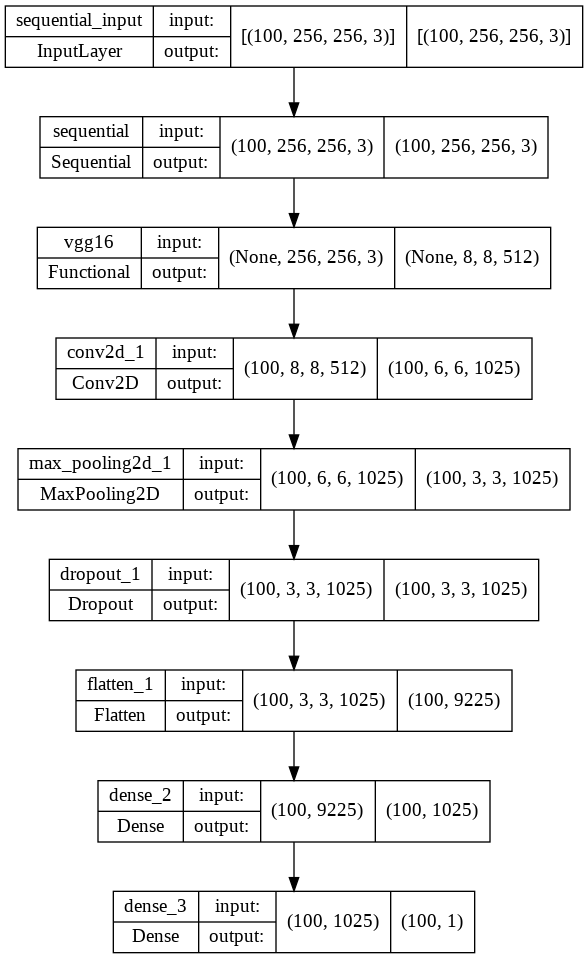

In [12]:
# Plot model graph
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (100, 256, 256, 3)        0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)           (100, 6, 6, 1025)         4724225   
                                                                 
 max_pooling2d_1 (MaxPooling  (100, 3, 3, 1025)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (100, 3, 3, 1025)         0         
                                                                 
 flatten_1 (Flatten)         (100, 9225)               0         
                                                      

In [14]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy','TruePositives','TrueNegatives','FalsePositives','FalseNegatives']
)

In [15]:
history = model.fit(
    train_ds,
    epochs=20,
    verbose=1,
    # validation_data=val_ds
)

Epoch 1/20
57/57 [==============================] - 27s 232ms/step - loss: 0.9063 - accuracy: 0.5806 - true_positives: 602.0000 - true_negatives: 457.0000 - false_positives: 407.0000 - false_negatives: 358.0000
Epoch 2/20
57/57 [==============================] - 13s 223ms/step - loss: 0.6244 - accuracy: 0.6513 - true_positives: 647.0000 - true_negatives: 541.0000 - false_positives: 323.0000 - false_negatives: 313.0000
Epoch 3/20
57/57 [==============================] - 12s 213ms/step - loss: 0.5569 - accuracy: 0.7149 - true_positives: 735.0000 - true_negatives: 569.0000 - false_positives: 295.0000 - false_negatives: 225.0000
Epoch 4/20
57/57 [==============================] - 12s 211ms/step - loss: 0.4941 - accuracy: 0.7571 - true_positives: 766.0000 - true_negatives: 615.0000 - false_positives: 249.0000 - false_negatives: 194.0000
Epoch 5/20
57/57 [==============================] - 12s 217ms/step - loss: 0.4233 - accuracy: 0.8048 - true_positives: 797.0000 - true_negatives: 671.0000 -

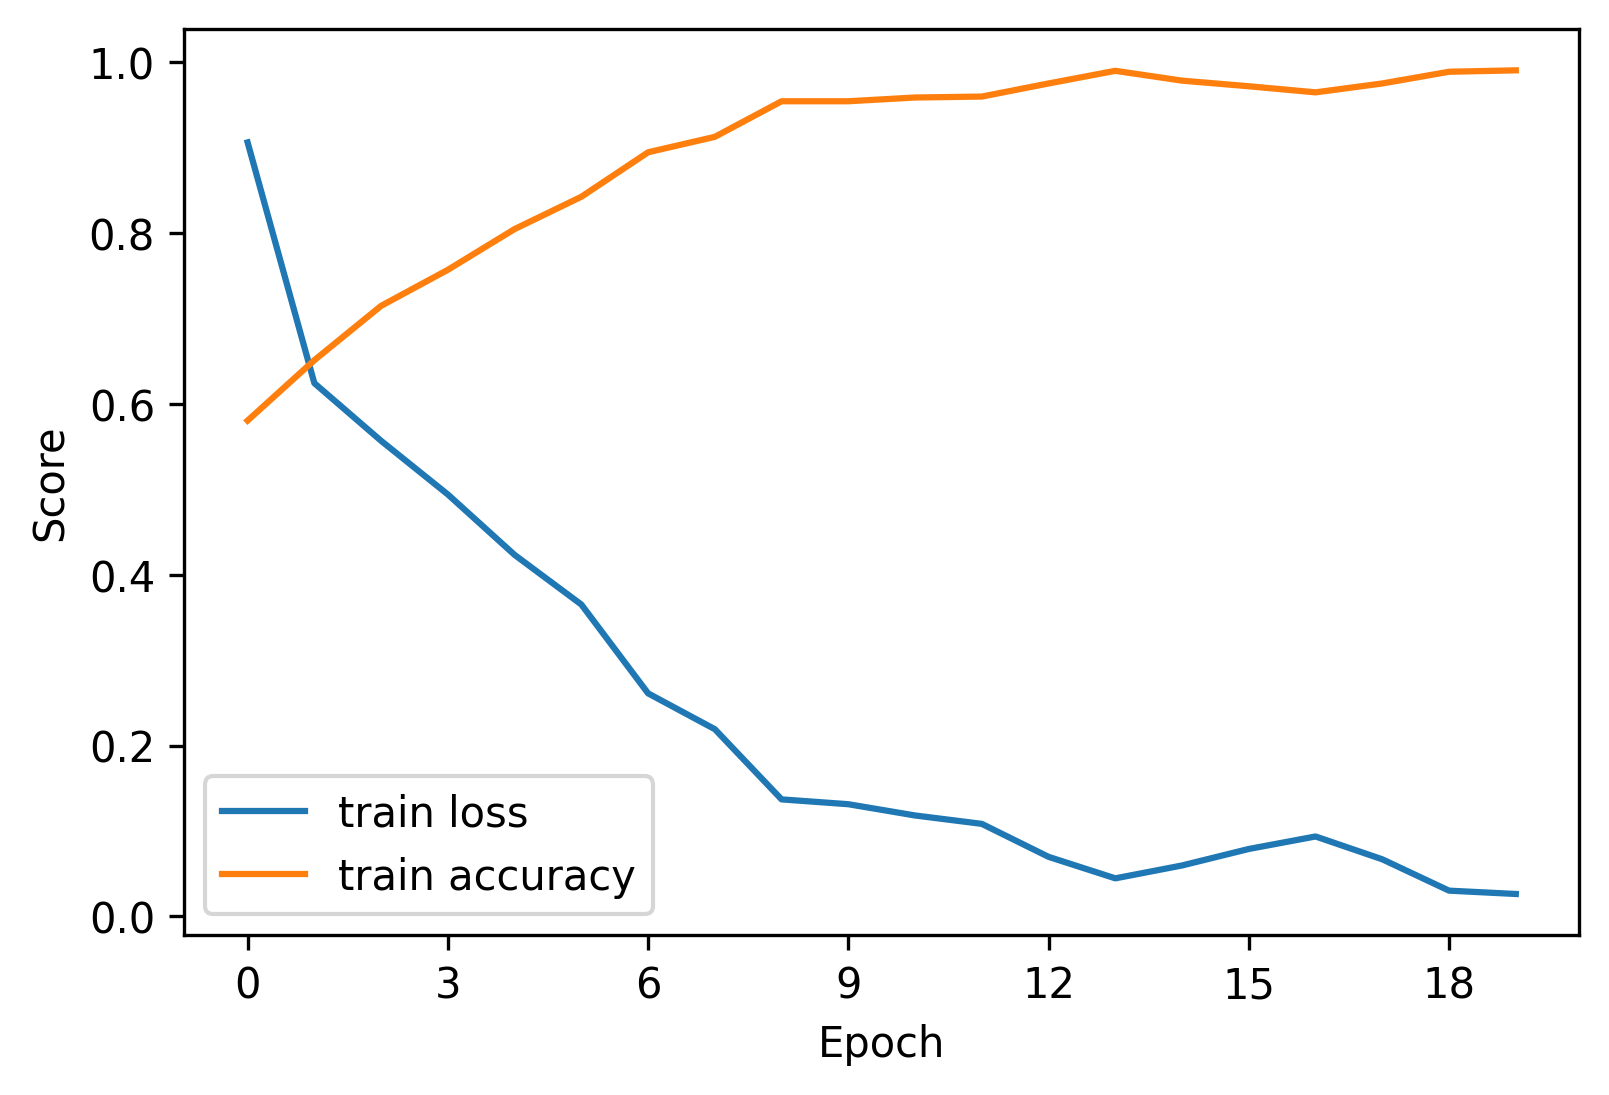

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['accuracy'], label='train accuracy')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

In [16]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 17s 616ms/step - loss: 0.2751 - accuracy: 0.9401 - true_positives: 105.0000 - true_negatives: 99.0000 - false_positives: 6.0000 - false_negatives: 7.0000


In [18]:
print('loss: ',scores[0])
print('accuracy: ',round(scores[1],2))
true_positives=int(scores[2])
true_negatives=int(scores[3])
false_positives=int(scores[4])
false_negatives=int(scores[5])
print('true_positives: ',true_positives)
print('true_negatives: ',true_negatives)
print('false_positives: ',false_positives)
print('false_negatives: ',false_negatives)
PrecisionScore = true_positives / (false_positives + true_positives)
print('Precision Score: ',round(PrecisionScore,2))
RecallScore = true_positives / (false_negatives + true_positives)
print('Recall Score: ',round(RecallScore,2))
F1Score = (2* PrecisionScore * RecallScore)/ (PrecisionScore + RecallScore)
print('F1 Score: ',round(F1Score,2))
Specificity = true_negatives/(true_negatives+false_positives)
print('Specificity : ',round(Specificity,2))


loss:  0.2751459777355194
accuracy:  0.94
true_positives:  105
true_negatives:  99
false_positives:  6
false_negatives:  7
Precision Score:  0.95
Recall Score:  0.94
F1 Score:  0.94
Specificity :  0.94


In [20]:
import math 
print('geometric mean:', math.sqrt(95*94))

geometric mean: 94.4986772394196


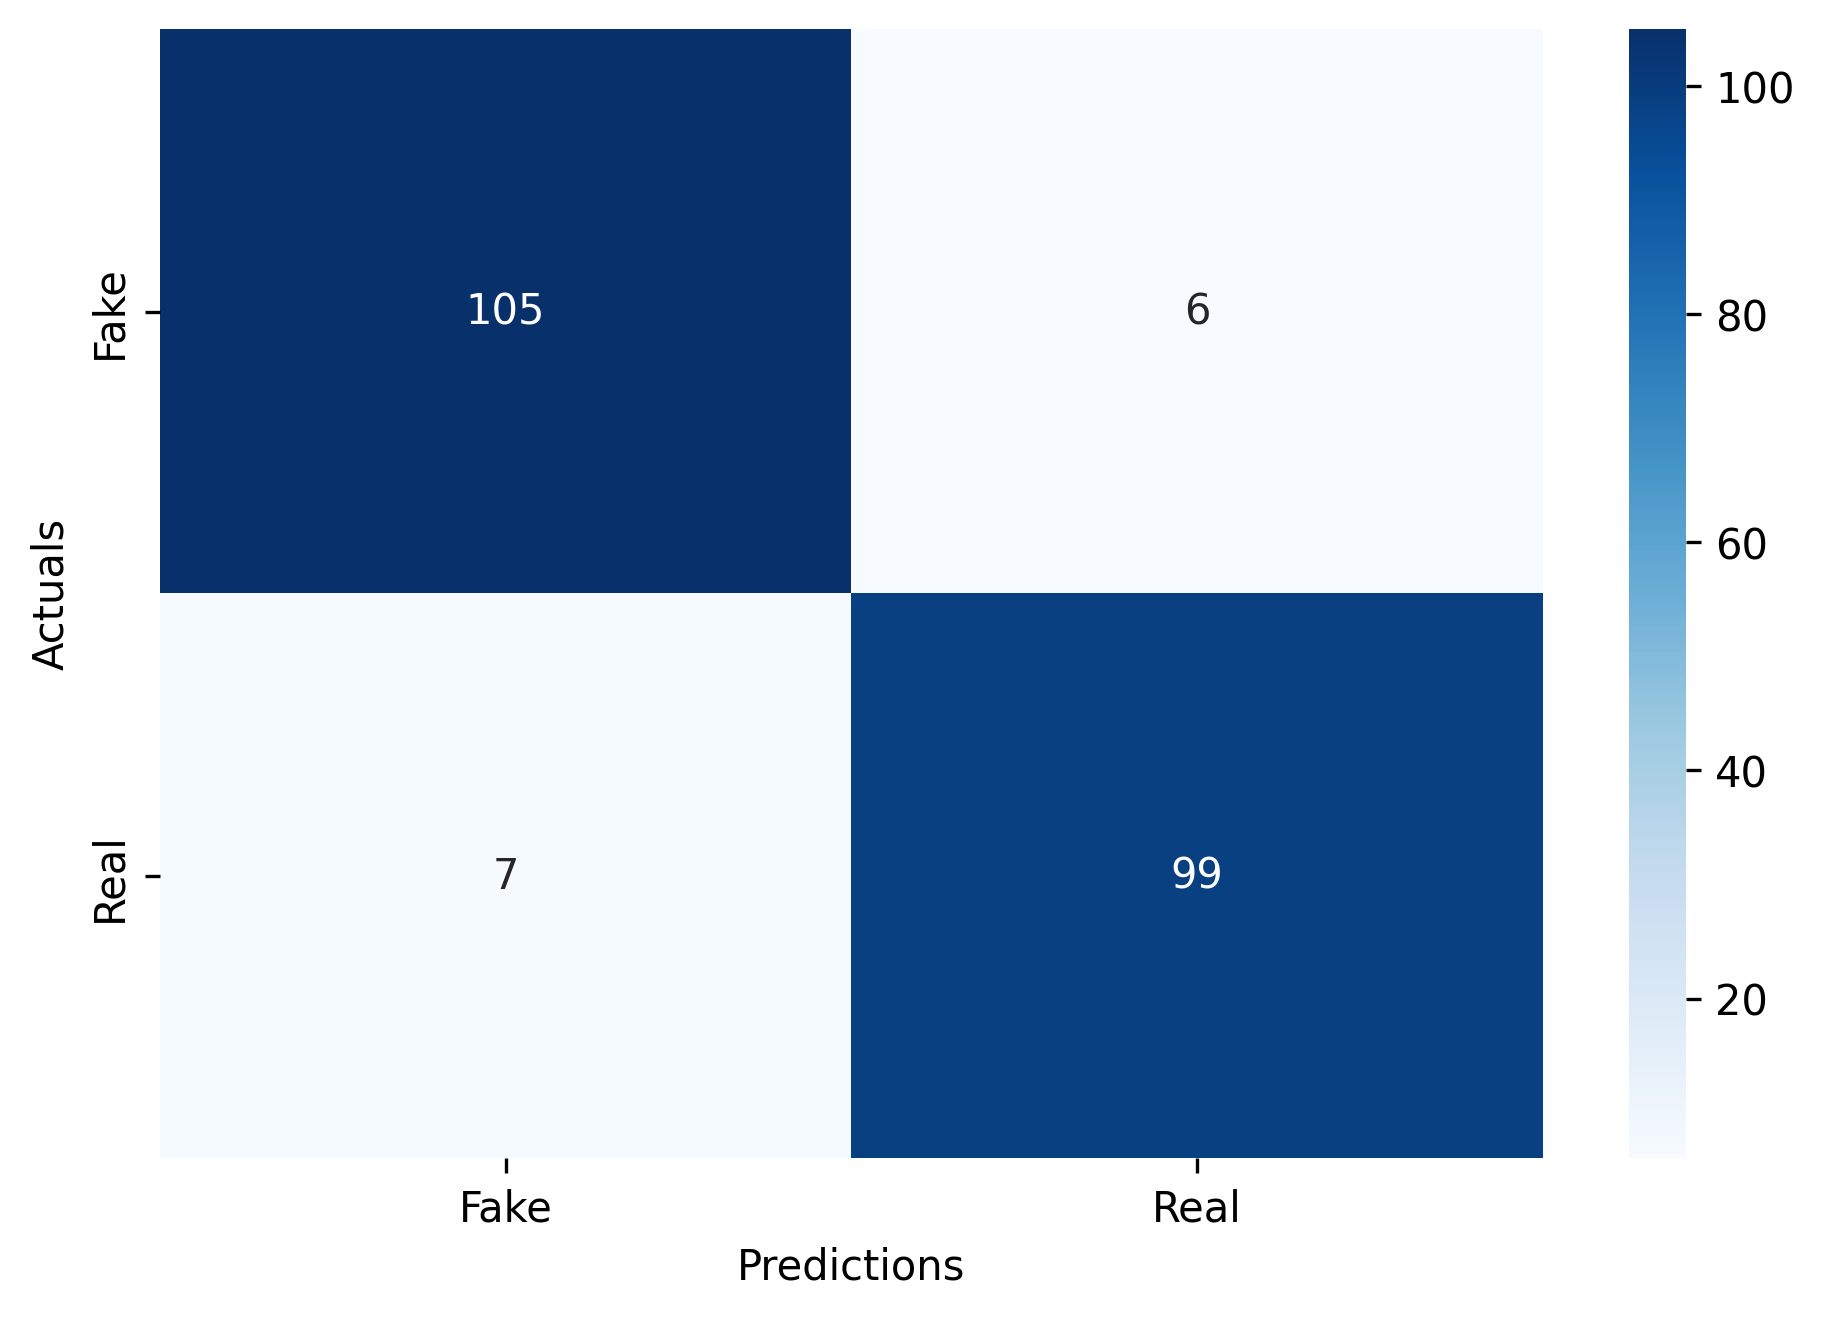

In [19]:
import seaborn as sns
data = [[true_positives, false_positives],[false_negatives, true_negatives]]
ax = sns.heatmap(data, fmt='', cmap='Blues',annot=True)
ax.xaxis.set_ticklabels(['Fake','Real'])
ax.yaxis.set_ticklabels(['Fake','Real'])
plt.tight_layout(pad=0)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
# plt.savefig('lrcm.pdf')
plt.show()